# 02. Neural Network classification with PyTorch

## 1. Make classification Data and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X,y = make_circles(n_samples,
                   noise=0.03, # Without noise, we get points on two perfectly concentric circles
                   random_state=42) # same as random seed setting
X.shape,y.shape

((1000, 2), (1000,))

In [2]:
print(f"First 5 samples of X: {X[:5]}")
print(f"first 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 samples of y: [1 1 1 1 0]


In [3]:
# Make dataframes of circles data
import pandas as pd

circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})

circles.head(10)


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

This shows that we have 500 data points that belong to class 0 and 500 data points that belong to class 1

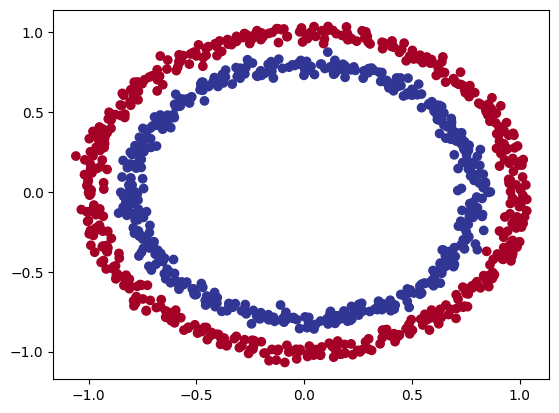

In [5]:
# Visualize, Visualize, Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap='RdYlBu')

As we can see, `make_circles` dataset is a list of points thaat makeup two concentric circles each describing two classes `0` and `1`.

The attributes of X are (Feature matrix), x and y coordinates of the points that either belong to Class 0 and Class 1.

Datasets like `make_circles` in scikit-learn are called Toy datasets as they are small, but, large enough to train our models

### 1.1 Check input and output shapes

In [6]:
X.shape,y.shape

((1000, 2), (1000,))

In [7]:
X[:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [8]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y is {y_sample}")
print(f"Shape for one sample of X: {X_sample.shape} and the same for y is {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y is 1
Shape for one sample of X: (2,) and the same for y is ()


In [9]:
X[0],y[0]

(array([0.75424625, 0.23148074]), 1)

Hence, we can see that the X[0] has shape 1 and y[0] has just a scalar

### 1.2 Turn data into tensors and create train and test splits

In [10]:
# Turn data into tensors
import torch
torch.__version__

'2.2.1+cu121'

In [11]:
type(X)

numpy.ndarray

In [12]:
# Turn data from ndarray into tensors
X = torch.from_numpy(X).type(torch.float) # Converts to PyTorch's default: float32
y = torch.from_numpy(y).type(torch.float)

X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
type(X),X.dtype,y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [14]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 0.2 is 20% will be test dataset and 80% is train dataset
                                                    random_state=42)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [15]:
len(X_train), len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code, so that our code will run on GPU if there is one
2. Construct a model (by subclassing `nn.Module)
3. Define loss function and optimizer
4. Create a training and test loop

In [16]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now, we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass it)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Override the `forward()` method - Have to do this as we are subclassing `nn.Module`
4. Instantiate an instance our model class and send it to the target `device`

In [17]:
# Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # Create 2 nn.Linear layers capable of handling the shape of our input data
    self.layer_1 = nn.Linear(in_features=2,out_features=5) # in_features is how many values of X are there in each row, out_features is arbitrary and we can change this value -> Hidden neurons. So, takes in 2 features and upscales them into 5 features
    self.layer_2 = nn.Linear(in_features=5,out_features=1) # takes in 5 features from previous layers and outputs 1 feature -> same as shape of y

    # 3. Define a forward() method that outlines the forward pass
    def forward(self,x):
      return self.layer_2(self.layer_1(X)) # X -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
device

'cuda'

In [19]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [20]:
# Let's replicate the model using nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Using this `nn.Sequential`, we can create the same model instead of writing the forward() method on our own. But, it is a good practice to subclass the `nn.Module` and writing the `forward` method as it comes in handy when we are creating a much complicated neural network

In [21]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2788,  0.2360],
                      [-0.3932,  0.0358],
                      [ 0.6785,  0.5297],
                      [-0.0452,  0.0730],
                      [ 0.0723, -0.7041]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.4340, -0.3509, -0.4090, -0.6942,  0.6697], device='cuda:0')),
             ('1.weight',
              tensor([[-0.4052, -0.3875,  0.0987,  0.0555, -0.2705]], device='cuda:0')),
             ('1.bias', tensor([-0.0214], device='cuda:0'))])

In [22]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nRounded first 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\n First 10 labels:\n{y_test[:10]}")


Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.2592],
        [-0.1882],
        [-0.4237],
        [-0.2127],
        [-0.3894],
        [-0.3463],
        [-0.1736],
        [-0.2105],
        [-0.4249],
        [-0.1831]], device='cuda:0')

Rounded first 10 predictions:
tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]], device='cuda:0')

 First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


We can see that the predictions and the labels are very different from each other.
Even with rounding off, the outputs would be very different than the labels


### 2.1 Setup loss function and optimizer

Which loss function and optimizer should we use?

**Loss functions:**

For example, for regression problems we might want **MAE** or **MSE** (Mean absolute error or Mean squared error)
For classification problems, we might use **BCE** or **CCE** (Binary cross entropy or categorical cross entropy)
**Note:** There is **BCELoss** and **BCEWithLogitsLoss** . We will explore this further. We are currently using **BCEWithLogitsLoss**.

As for optimizers, SGD and Adam are two most important ones although there are several other kinds of optimizers.






In [23]:
# Setup the loss function

# loss_fn = BCELoss() # Requires inputs that have gone through the sigmoid activation fn prior to being input to BCELoss()

# nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss()
# ) # Same as BCEWithLogitsLoss()

loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss has sigmoid() activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)

In [24]:
# Calculate accuracy -> (TP/TP+TN) * 100
# Out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item() # How many of the y_true, y_pred are equal and their summation
  acc = (correct/len(y_pred))*100
  return acc

In [25]:
A_preds = torch.round(torch.rand(10,1)).squeeze()
print(f"{A_preds}, {A_preds.shape}")
A_true = torch.round(torch.rand(10,1)).squeeze()
print(f"{A_true}, {A_true.shape}")
correct_A = torch.eq(A_preds,A_true)
print(correct_A)
print(f"Number of correct matches:{correct_A.sum()} and the datatype of correct_A.sum() is:{correct_A.sum().dtype}") # torch integer type
print(correct_A.sum().item()) # conversion to normal integer
acc_A = (correct_A.sum().item()/len(A_preds))*100
print(f"Accuracy of A: {acc_A}")

tensor([0., 0., 0., 0., 0., 0., 1., 0., 1., 1.]), torch.Size([10])
tensor([0., 1., 1., 1., 1., 1., 1., 0., 0., 0.]), torch.Size([10])
tensor([ True, False, False, False, False, False,  True,  True, False, False])
Number of correct matches:3 and the datatype of correct_A.sum() is:torch.int64
3
Accuracy of A: 30.0


### 3. Training a model

To train a model, we have to build a training loop.

 for epoch in the range
1) do the forward pass
2) Calculate the loss
3) optimizer zero_grad
4) loss.backward() (Back propogation)
5) optimizer step step step (Gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them into some kind of activation function (e.g., sigmoid for binary classification, softmax for multi-class classification)

Then we can convert the model's prediction_probabilities to prediction labels by either rounding them or using `argmax()`

In [26]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2592],
        [-0.1882],
        [-0.4237],
        [-0.2127],
        [-0.3894]], device='cuda:0')

In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [28]:
# Use the sigmoid function on the logits to convert them into prediction probabilitites
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4356],
        [0.4531],
        [0.3956],
        [0.4470],
        [0.4039]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:

* y_pred_probs >= 0.5, y=1 (Class 1)
* y_pred_probs < 0.5, y=0 (Class 0)

We can choose the threshold of our model

In [29]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full [logits -> pred_probs -> pred_labels] in one hit
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(),y_pred_labels.squeeze()))

# Get rid of extra dimensions
y_preds.squeeze()


tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

In [30]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

They are different as the model is untrained. Now, we train our model to bring down the loss

### 3.2. setting up the training and test loops

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 100

# Put the data to the target device
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Do the forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred_probs -> pred_labels

  # 2. Calculate the loss and accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # If nn.BCELoss() we need to input prediction probabilities
  #                y_train)
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (back propogation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the test loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)

    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # note the loss function arguments are predictions first and then actual labels
    # In accuracy function that we have defined in correspondence with scikit accuracy functions
    # We give the labels first and the predictions after

    # Print out what's happening
    if epoch%10==0:
      print(f"Epoch: {epoch} | Train_Loss: {loss:.5f}, Train_Acc: {acc:.2f}% | Test loss: {test_loss}, test_acc = {test_acc:.2f}%")





Epoch: 0 | Train_Loss: 0.70654, Train_Acc: 50.00% | Test loss: 0.7084861397743225, test_acc = 50.00%
Epoch: 10 | Train_Loss: 0.69620, Train_Acc: 50.00% | Test loss: 0.698839545249939, test_acc = 50.00%
Epoch: 20 | Train_Loss: 0.69383, Train_Acc: 43.88% | Test loss: 0.6962915062904358, test_acc = 47.50%
Epoch: 30 | Train_Loss: 0.69326, Train_Acc: 48.50% | Test loss: 0.695503830909729, test_acc = 48.00%
Epoch: 40 | Train_Loss: 0.69312, Train_Acc: 49.62% | Test loss: 0.6951966881752014, test_acc = 47.00%
Epoch: 50 | Train_Loss: 0.69307, Train_Acc: 50.12% | Test loss: 0.6950414776802063, test_acc = 48.50%
Epoch: 60 | Train_Loss: 0.69305, Train_Acc: 50.50% | Test loss: 0.6949450373649597, test_acc = 47.50%
Epoch: 70 | Train_Loss: 0.69304, Train_Acc: 50.62% | Test loss: 0.6948769688606262, test_acc = 47.00%
Epoch: 80 | Train_Loss: 0.69303, Train_Acc: 50.88% | Test loss: 0.6948254108428955, test_acc = 47.00%
Epoch: 90 | Train_Loss: 0.69302, Train_Acc: 50.62% | Test loss: 0.6947848200798035, t

## 4. Make predictions and evaluate the model

From the metrics, it looks like our model isn't learning anything......

So, let us Visualize, Visualize, Visualize !! to inspect it

To do so, we are going to import a function called `plot_decision_boundary()` from

Daniel's github repo - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [32]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions,plot_decision_boundary

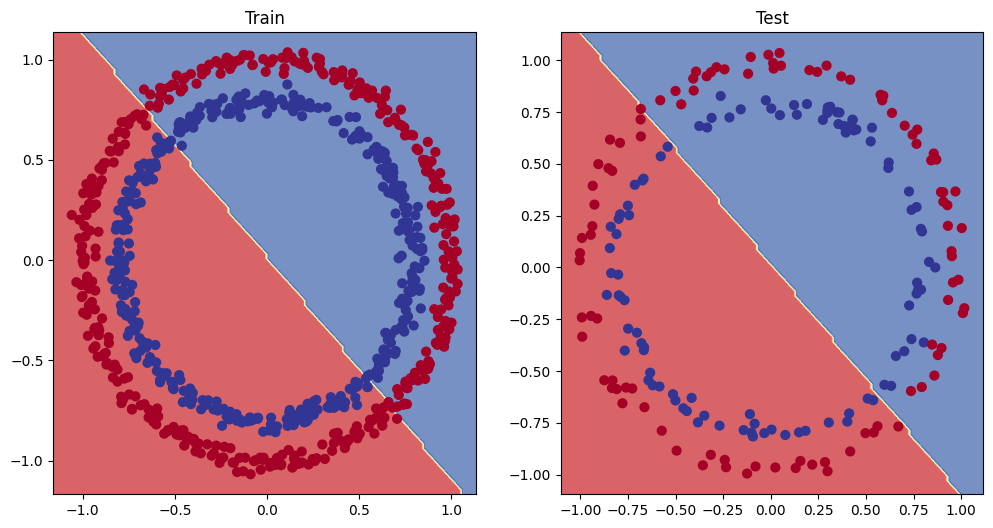

In [33]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)


## 5. Improving the model (from a model perspective)

* Add more layers - give the model more chances to learn about the patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate (Dealing with exploding and vanishing gradient problems)
* Change the loss function
* Train for more epochs

 All these options are with respect to model as all these directly deal with the model, rather than the data.

 All these above options are values called **"hyperparameters"**

 Let's try to improve our model by:

 * Adding more hidden units: 5 -> 10
 * Increase the number of layers: 2 -> 3
 * Increase the number of epochs: 100 -> 1000
  

In [34]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)

  def forward(self,x):
    # z = self.layer_1(x) # normally, logits are represented by z
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed-ups where it is necessary

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [35]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.1)

In [36]:
# Training loop and evaluation of model_1

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train,y_train,X_test,y_test = X_train.to(device),y_train.to(device),X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  # Do the forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits-> pred_probabilities ->prediction labels

  # Calculate the loss/accuracy
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # optimizer zero grad
  optimizer.zero_grad()

  # loss.backward() -> Back propogation
  loss.backward()

  # optimizer step step step (Gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    #1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2.Calculate the test loss/ac
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred )

    # Print out what's happening
    if epoch % 100 ==0:
      print(f"Epoch:{epoch} | Training Loss: {loss:.5f} | Acc={acc:.2f} | Test_loss: {test_loss:.5f} | test_accuracy: {test_acc:.2f} ")



Epoch:0 | Training Loss: 0.69396 | Acc=50.88 | Test_loss: 0.69261 | test_accuracy: 51.00 
Epoch:100 | Training Loss: 0.69305 | Acc=50.38 | Test_loss: 0.69379 | test_accuracy: 48.00 
Epoch:200 | Training Loss: 0.69299 | Acc=51.12 | Test_loss: 0.69437 | test_accuracy: 46.00 
Epoch:300 | Training Loss: 0.69298 | Acc=51.62 | Test_loss: 0.69458 | test_accuracy: 45.00 
Epoch:400 | Training Loss: 0.69298 | Acc=51.12 | Test_loss: 0.69465 | test_accuracy: 46.00 
Epoch:500 | Training Loss: 0.69298 | Acc=51.00 | Test_loss: 0.69467 | test_accuracy: 46.00 
Epoch:600 | Training Loss: 0.69298 | Acc=51.00 | Test_loss: 0.69468 | test_accuracy: 46.00 
Epoch:700 | Training Loss: 0.69298 | Acc=51.00 | Test_loss: 0.69468 | test_accuracy: 46.00 
Epoch:800 | Training Loss: 0.69298 | Acc=51.00 | Test_loss: 0.69468 | test_accuracy: 46.00 
Epoch:900 | Training Loss: 0.69298 | Acc=51.00 | Test_loss: 0.69468 | test_accuracy: 46.00 


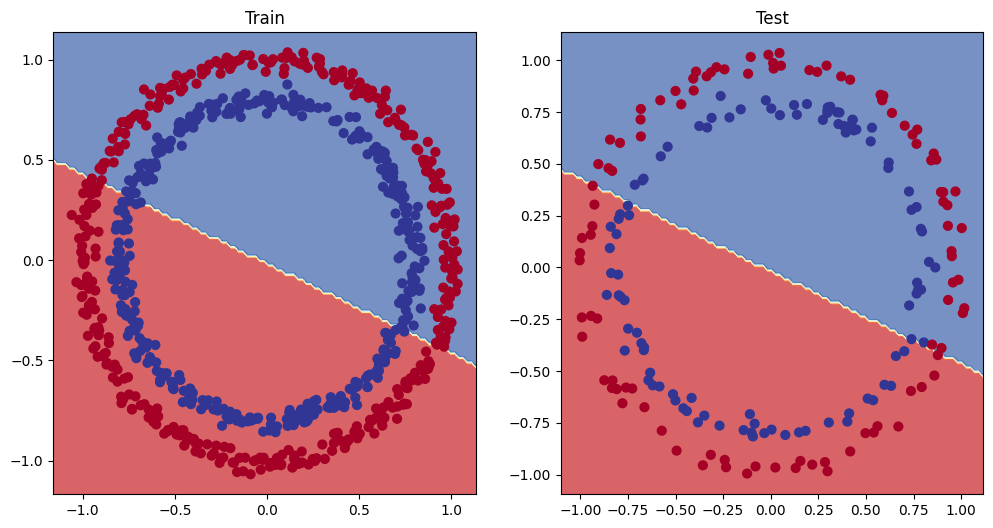

In [37]:
# Plot decision boundary of the model_1

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)


Even now, we can see that the model did not improve much. The decision boundaries are still linear. And by the plots it is clear that we need a non_linear decision boundary.

A NON_LINEAR_MODEL ???

Or our model is just too stupid to learn anything?

Let us test this by applying our model to predict regression values as done previously and understand how good our model works with regression problems !!!

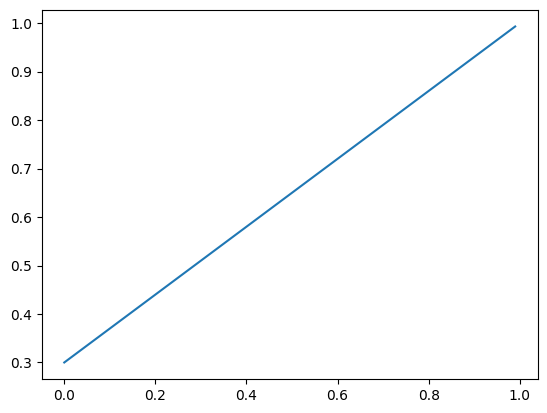

In [38]:
# Creating a linear dataset
import numpy as np

start=0
end=1
step=0.01

X = torch.arange(start,end,step).unsqueeze(dim=1)

weight = 0.7
bias = 0.3

y = weight * X + bias

plt.plot(X.numpy(),y.numpy())

In [39]:
X[:5],y[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [40]:
y.shape, X.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [41]:
# Creating X_train,y_train, X_test,y_test
train_split  = int(0.8*len(X))
X_train = X[:train_split]
y_train = y[:train_split]
X_test = X[train_split:]
y_test = y[train_split:]

len(X_train),len(y_train),len(X_test),len(y_test)

(80, 80, 20, 20)

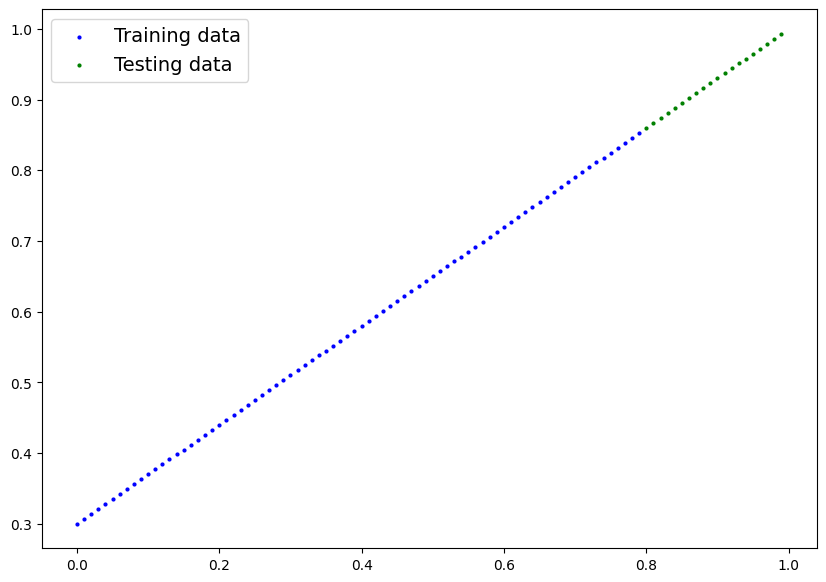

In [42]:
plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test
                 )

In [43]:
# Modifying model 1 to meet the needs of the regression problem

model_2 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [44]:
# Creating a linear regression loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)
loss_fn, optimizer

(L1Loss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [45]:
# Training and testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 2000

# Exporting data to the target device
X_train,y_train,X_test,y_test = X_train.to(device),y_train.to(device),X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # Do the forward pass
  y_pred = model_2(X_train)

  # Calculate the loss
  loss = loss_fn(y_pred,y_train)

  # Optimizer zero grad
  optimizer.zero_grad()

  # loss.backward()
  loss.backward()

  # Optimizer step step step
  optimizer.step()

  ### Testing
  model_2.eval()
  with torch.inference_mode():
    # Do the forward pass
    test_pred = model_2(X_test)
    # Calculate the loss
    test_loss = loss_fn(test_pred,y_test)

    # Print what is happening
    if epoch%100 == 0:
      print(f"Epoch:{epoch} | Training_Loss:{loss:.5f} | Test_loss:{test_loss:.5f}")


Epoch:0 | Training_Loss:0.75986 | Test_loss:0.91103
Epoch:100 | Training_Loss:0.02858 | Test_loss:0.00081
Epoch:200 | Training_Loss:0.02533 | Test_loss:0.00209
Epoch:300 | Training_Loss:0.02137 | Test_loss:0.00305
Epoch:400 | Training_Loss:0.01964 | Test_loss:0.00341
Epoch:500 | Training_Loss:0.01940 | Test_loss:0.00387
Epoch:600 | Training_Loss:0.01903 | Test_loss:0.00379
Epoch:700 | Training_Loss:0.01878 | Test_loss:0.00381
Epoch:800 | Training_Loss:0.01840 | Test_loss:0.00329
Epoch:900 | Training_Loss:0.01798 | Test_loss:0.00360
Epoch:1000 | Training_Loss:0.01782 | Test_loss:0.00333
Epoch:1100 | Training_Loss:0.01674 | Test_loss:0.00317
Epoch:1200 | Training_Loss:0.01640 | Test_loss:0.00316
Epoch:1300 | Training_Loss:0.01648 | Test_loss:0.00256
Epoch:1400 | Training_Loss:0.01648 | Test_loss:0.00323
Epoch:1500 | Training_Loss:0.01632 | Test_loss:0.00337
Epoch:1600 | Training_Loss:0.01596 | Test_loss:0.00284
Epoch:1700 | Training_Loss:0.01458 | Test_loss:0.00244
Epoch:1800 | Training_

In [46]:
test_loss

tensor(0.0331, device='cuda:0')

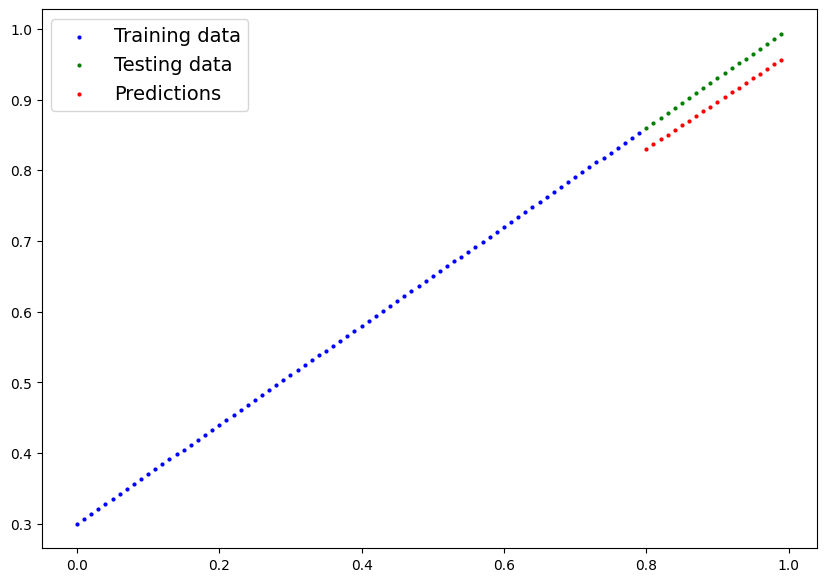

In [47]:
# Evaluate the model
model_2.eval()
with torch.inference_mode():
  y_preds = model_2(X_test)

 # Plot data and predictions

plot_predictions(train_data=X_train.cpu(),
                 train_labels=y_train.cpu(),
                 test_data=X_test.cpu(),
                 test_labels=y_test.cpu(),
                 predictions=y_preds.cpu())



Hence, we can conclude that our model's architecture is working good with a linear regression problem. So, with the new data, we can see that the model has the capacity to work.

So, the problem is with the correlation between the model and the circles data.

So, NON_LINEAR_MODELS !!!

We have just prepared the model with linear layers. So, the model fails to understand the non-linear data patterns.

Hence, inorder to understand the non-linear data patterns, non-linearity must be introduced to the layers of the model !!!

With infinite amount of straight and non-straight lines, we can almost understand any pattern

 ### 6.1. Recreating non-linear data (red and blue circles)

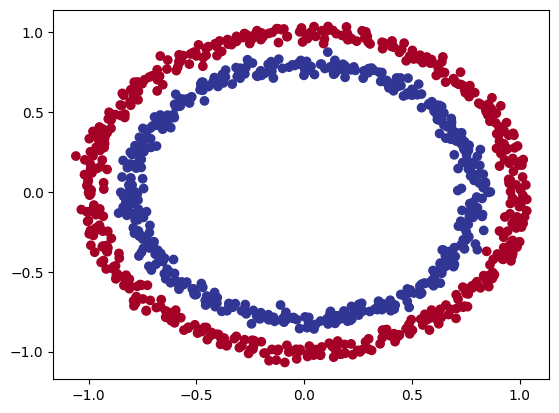

In [48]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu);

In [49]:
# Convert data into tensors and then split into train and test datasets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

# Split into train and test datasets
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

In [50]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

### 6.2. Building a model with non-linearity

In [51]:
# Build a model with non-linear activation functions

from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU() # ReLU is a non-linear activation function

  def forward(self,x):
    # Where should we put our non_linear activation functions
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [52]:
# Creating a loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.1
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [53]:
# Training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 2000

# Setting up the parameters on the target device
X_train,X_test,y_train,y_test = X_train.to(device),X_test.to(device),y_train.to(device),y_test.to(device)

for epoch in range(epochs):

  # Training mode
  model_3.train()

  # Do the forward pass
  y_logits = model_3(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels


  # Calculate the loss/acc
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_preds)

  # Optimizer zero grad
  optimizer.zero_grad()

  # loss.backward()
  loss.backward()

  # Optimizer step step step
  optimizer.step()

  # Testing loop
  model_3.eval()
  with torch.inference_mode():

    # Do the forward pass
    y_test_logits = model_3(X_test).squeeze()
    y_test_preds = torch.round(torch.sigmoid(y_test_logits))

    # Calculate the loss/acc
    test_loss = loss_fn(y_test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=y_test_preds)

  # Print what's happening
  if epoch % 200 == 0:
    print(f"Epoch:{epoch} | Training Loss: {loss:.4f} | Train_accuracy = {acc:.2f} | Test_loss: {test_loss:.4f} | Test_accuracy: {test_acc:.2f}")



Epoch:0 | Training Loss: 0.6929 | Train_accuracy = 50.00 | Test_loss: 0.6932 | Test_accuracy: 50.00
Epoch:200 | Training Loss: 0.6898 | Train_accuracy = 53.37 | Test_loss: 0.6894 | Test_accuracy: 55.00
Epoch:400 | Training Loss: 0.6852 | Train_accuracy = 52.75 | Test_loss: 0.6841 | Test_accuracy: 56.50
Epoch:600 | Training Loss: 0.6751 | Train_accuracy = 54.50 | Test_loss: 0.6729 | Test_accuracy: 56.00
Epoch:800 | Training Loss: 0.6516 | Train_accuracy = 64.00 | Test_loss: 0.6476 | Test_accuracy: 67.50
Epoch:1000 | Training Loss: 0.5682 | Train_accuracy = 87.75 | Test_loss: 0.5738 | Test_accuracy: 86.50
Epoch:1200 | Training Loss: 0.3706 | Train_accuracy = 97.75 | Test_loss: 0.4059 | Test_accuracy: 92.00
Epoch:1400 | Training Loss: 0.1718 | Train_accuracy = 99.50 | Test_loss: 0.2211 | Test_accuracy: 97.50
Epoch:1600 | Training Loss: 0.0912 | Train_accuracy = 99.88 | Test_loss: 0.1274 | Test_accuracy: 99.50
Epoch:1800 | Training Loss: 0.0577 | Train_accuracy = 99.88 | Test_loss: 0.0867 

### 6.4 Evaluating a model trained with non-linear activation functions

In [54]:
# Makes predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test).squeeze()))

y_preds.shape,y_test.shape

(torch.Size([200]), torch.Size([200]))

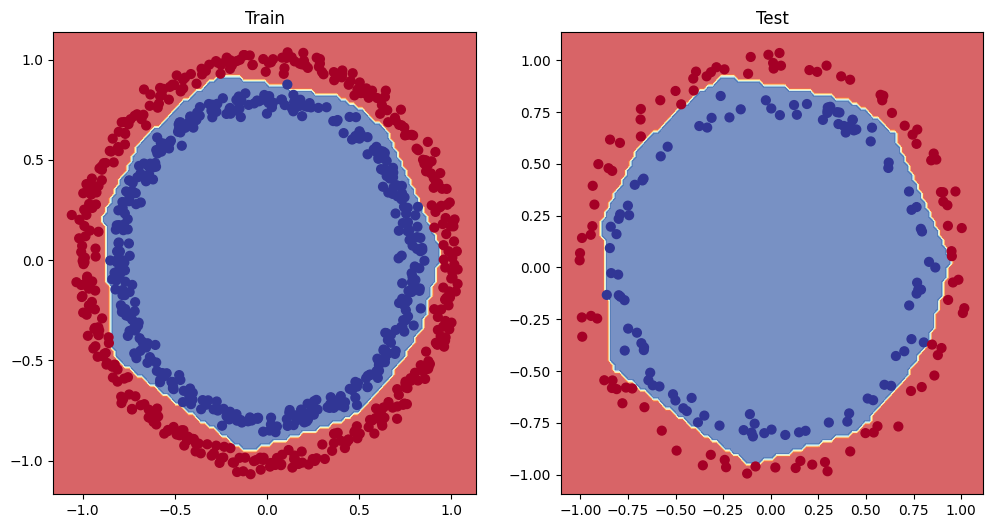

In [55]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,y_test)

Conclusions:

 Epochs -- No of hidden units -- No of hidden layers -- Training acc -- Test acc

 1000 -- 10 -- 2 -- 74% -- 79%

 2000 -- 10 -- 2 -- 99.88% -- 99.5%

 1000 -- 20 -- 2 -- 99.38% -- 98%

 1000 -- 10 -- 3 -- 54.75% --54%




## 7. Putting it all together with a multi-class classification problem

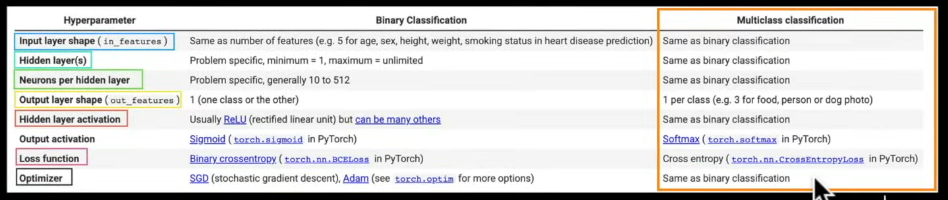

### 7.1 Creating a toy multi-class dataset

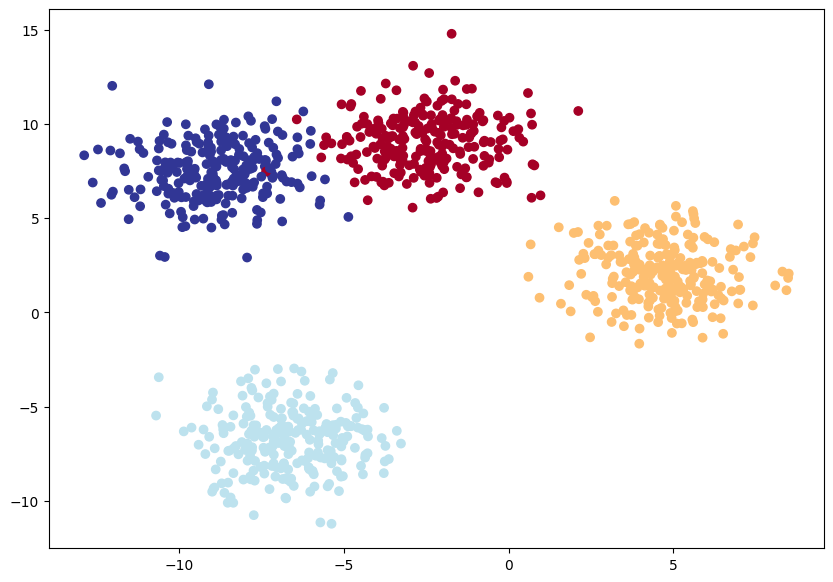

In [112]:
# Import dependencies

import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# 1. Set the hyperparameters for the data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 2. Creating multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,# give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 3. Turn data into tensors

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 4. Split into train and test datasets

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 5. Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu);

### 7.2 Building a multi-class classification model

In [113]:
# Create a device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [114]:
from torch import nn

class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    """Initializes multi-class classification model

    Args:
    input_features (int): Number of input features to the model
    out_put_features (int): Number of output features (no of output classes)
    hidden_units (int): Number of hidden units between layers, defaults 8

    Returns:
    """
    super().__init__()
  # We can either use this or nn.Sequential as we are currently using
  #   self.layer_1 = nn.Linear(in_features=NUM_FEATURES,out_features=10)
  #   self.layer_2 = nn.Linear(in_features=10,out_features=10)
  #   self.layer_3 = nn.Linear(in_features=10,out_features=NUM_CLASSES)
  #   self.relu = nn.ReLU()

  # def forward(self,x):
  #   return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

# Create an instance of the BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [115]:
X_blob_train.shape,y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [116]:
torch.unique(y_blob_train) # Gives the number of different classes in the y_blob_train

tensor([0, 1, 2, 3])

## 7.3 Creating a loss function and an optimizer for the multi-class classification problem

In [117]:
# Create a loss function
# We typically use Cross-entropy loss function with multi-class classification problem
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer
# We either use an SGD/Adam optimizer with the multi-class classification problem
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1) # learning rate is a hyperparameter we can change

loss_fn, optimizer

(CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.1
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

## 8.4 Getting prediction probabilities for a multi-class PyTorch model

In [118]:
# Let's get the raw outputs of the model
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [119]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

We can see that contrary to the y_blob_test "labels", our predictions have 4 values in every row. This is because our output features are the number of classes which is "4". Now, we have to convert these raw outputs (logits) into the prediction probabilities and then assign the values to the class (prediction labels), based on what class among the predictions has the highest prediction probability.

logits -> prediction probabilities -> prediction labels


In [120]:
# Converting logit outputs into prediction probabilities

y_pred_probs = torch.softmax(y_logits,dim=1) # Across the first dimension (rows)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [121]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [122]:
torch.max(y_pred_probs[0])

tensor(0.3244, device='cuda:0')

In [123]:
torch.argmax(y_pred_probs[0])

tensor(1, device='cuda:0')

* The above softmax function gives us the prediction probabilities for each class.

* Hence, the sum of probabilities of the training example being in all the classes is 1.

* We can then see the highest prediction probability

* We can get the class corresponding to the highest prediction probability using **torch.argmax()**

In [124]:
# Convert our model's prediction probabilities into prediction labels
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [125]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [126]:
y_preds.shape, y_blob_test.shape

(torch.Size([200]), torch.Size([200]))

This is the right required shape for the testing labels. However, these are not correct labels as the model is still untrained.

### 7.5 Creating a training and testing loop for a multi-class classification model

In [127]:
# Training
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Sending data to the device
X_blob_train, X_blob_test, y_blob_train, y_blob_test = X_blob_train.to(device), X_blob_test.to(device), y_blob_train.to(device), y_blob_test.to(device)

epochs = 100

for epoch in range(epochs):

  # Training mode
  model_4.train()

  # Do the forward pass
  y_logits = model_4(X_blob_train)
  y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1) #logits -> prediction probabilities -> prediction labels


  # Calculate the loss/acc
  loss = loss_fn(y_logits, y_blob_train) # takes logits similar to the BCEWithLogits loss
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_preds)

  # optimizer zero_grad
  optimizer.zero_grad()

  # loss.backward()
  loss.backward()

  # Optimizer step step step
  optimizer.step()

  # Testing loop
  model_4.eval()
  with torch.inference_mode():
    # Do the forward pass
    y_test_logits = model_4(X_blob_test)
    y_test_preds = torch.softmax(y_test_logits,dim=1).argmax(dim=1)

    # Calculate the loss/acc
    test_loss = loss_fn(y_test_logits,y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=y_test_preds)

    # Print what's happenning
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Training loss: {loss:.4f} | Train acc: {acc:.2f} | Test loss: {test_loss:.4f} | test acc: {test_acc:.2f}")


Epoch: 0 | Training loss: 1.1588 | Train acc: 40.38 | Test loss: 1.0755 | test acc: 48.00
Epoch: 10 | Training loss: 0.6448 | Train acc: 96.75 | Test loss: 0.6607 | test acc: 97.50
Epoch: 20 | Training loss: 0.4254 | Train acc: 98.50 | Test loss: 0.4307 | test acc: 100.00
Epoch: 30 | Training loss: 0.2529 | Train acc: 99.12 | Test loss: 0.2451 | test acc: 99.50
Epoch: 40 | Training loss: 0.1123 | Train acc: 99.25 | Test loss: 0.1023 | test acc: 99.50
Epoch: 50 | Training loss: 0.0663 | Train acc: 99.25 | Test loss: 0.0585 | test acc: 99.50
Epoch: 60 | Training loss: 0.0507 | Train acc: 99.25 | Test loss: 0.0429 | test acc: 99.50
Epoch: 70 | Training loss: 0.0430 | Train acc: 99.25 | Test loss: 0.0349 | test acc: 99.50
Epoch: 80 | Training loss: 0.0384 | Train acc: 99.25 | Test loss: 0.0299 | test acc: 99.50
Epoch: 90 | Training loss: 0.0352 | Train acc: 99.25 | Test loss: 0.0266 | test acc: 99.50


In [128]:
# Evaluate the model

model_4.eval()
with torch.inference_mode():
  # Do the forward pass
  y_test_logits = model_4(X_blob_test)
  y_test_preds = torch.softmax(y_test_logits,dim=1).argmax(dim=1)

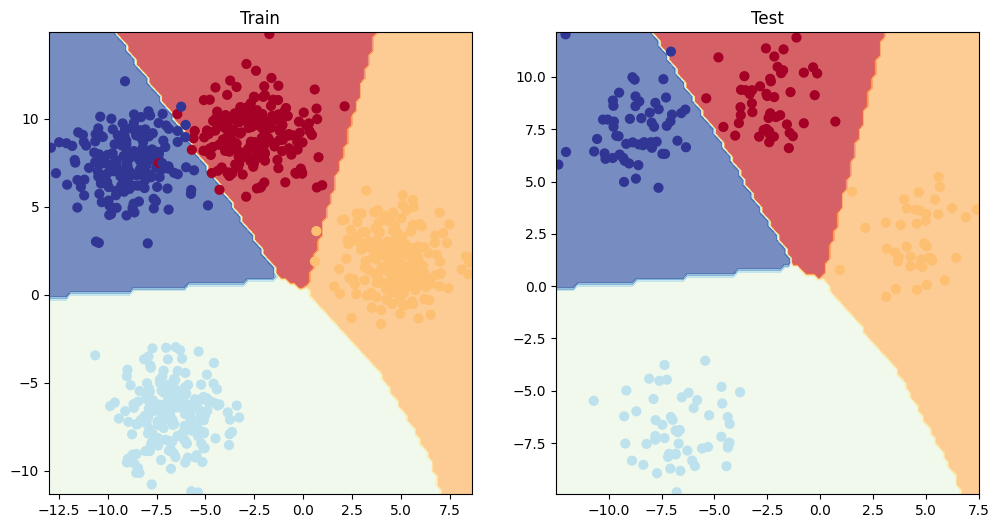

In [129]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,X_blob_test,y_blob_test)

## 9. A few more classification metrics ..(to further evaluate our classification model)

* Accuracy: Out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

See this article for when to use precision/recall - https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

If you want access to a lot of PyTorch metrics, see TorchMetrics - https://torchmetrics.readthedocs.io/en/latest/

Also checkout **Precision - recall trade off**

In [131]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 10.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [134]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task='multiclass',
                                num_classes=NUM_CLASSES).to(device)

# Calculate accuracy
torchmetric_accuracy(y_test_preds,y_blob_test)

tensor(0.9950, device='cuda:0')

Note that Accuracy function is updated and is dfrnt from the yt video